# TODO:

 - Use container for datasets and models - ?, for now from path
 - rifare tutto con msn - DONE
 - no_relevant_results - DONE
 - ">" =1 spiegat istanza la metrica - DONE
 - aggiungere linee orizzontali al bar - DONE
 - salvo check width barre - DONE
 - solo 3 cifre decimali, orizzontali o niente - DONE

# Effectiveness analysis 
Effectiveness analysis comprises multiple performance tests.

In the following notebook we will instruct/demonstrate how to load models and datasets, create metrics and perform the available effectiveness analyses and visualize and interpret the results:
 - Model performance
 - Tree-wise performance
 - Tree-Wise average Contribution
 - Query-wise performance
 - Query class performance
 - Document graded-relevance performance
 - Rank confusion matrix
        

#### Essential imports

In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
import xarray as xr

# Useful to reload the module without having to restart the notebook kernel
import rankeval.analysis.effectiveness
import rankeval.visualization.effectiveness
import rankeval.metrics
from rankeval.dataset.datasets_fetcher import load_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading datasets and models

In order to browse and load dataset and models the user can call the load_dataset utility. This tool is currently able to load datasets and 

In [2]:
# Dataset container
dataset_container = load_dataset(dataset_name='msn10k', 
                                fold='1', 
                                download_if_missing=True, 
                                force_download=False, 
                                with_models=True)

Loading files. This may take a few minutes.
done loading dataset!


## Datasets

In [3]:
# Remapping Datasets Names
msn_train = dataset_container.train_dataset
msn_validation = dataset_container.validation_dataset
msn_test = dataset_container.test_dataset

## Choose and load models

In [4]:
# View available models
dataset_container.model_filenames

[u'/home/rankeval/rankeval_data/msn10k/models/Fold1/lightgbm/msn1.lightgbm.LAMBDAMART.1000.32.T1000.model',
 u'/home/rankeval/rankeval_data/msn10k/models/Fold1/catboost/msn1.catboost.LAMBDAMART.1000.5.T1000.json',
 u'/home/rankeval/rankeval_data/msn10k/models/Fold1/catboost/msn1.catboost.LAMBDAMART.1000.5.T1000.model',
 u'/home/rankeval/rankeval_data/msn10k/models/Fold1/quickrank/msn1.quickrank.LAMBDAMART.20000.32.T20000.xml',
 u'/home/rankeval/rankeval_data/msn10k/models/Fold1/quickrank/msn1.quickrank.LAMBDAMART.20000.32.T5000.xml',
 u'/home/rankeval/rankeval_data/msn10k/models/Fold1/quickrank/msn1.quickrank.LAMBDAMART.20000.32.T1000.xml',
 u'/home/rankeval/rankeval_data/msn10k/models/Fold1/quickrank/msn1.quickrank.LAMBDAMART.20000.32.T15000.xml',
 u'/home/rankeval/rankeval_data/msn10k/models/Fold1/quickrank/msn1.quickrank.LAMBDAMART.20000.32.T10000.xml',
 u'/home/rankeval/rankeval_data/msn10k/models/Fold1/xgboost/msn1.xgboost.LAMBDAMART.1000.5.T1000.model']

In [5]:
# Model files
msn_qr_lmart_1Ktrees_file = dataset_container.model_filenames[5]
msn_qr_lmart_15Ktrees_file = dataset_container.model_filenames[6]
msn_xgb_lmart_1Ktrees_file = dataset_container.model_filenames[8]
msn_lgbm_lmart_1Ktrees_file = dataset_container.model_filenames[0]

In [6]:
# Loading Models
from rankeval.model import RTEnsemble

msn_qr_lmart_1Ktrees = RTEnsemble(msn_qr_lmart_1Ktrees_file, name="QR_lmart_1K", format="QuickRank")
msn_qr_lmart_15Ktrees = RTEnsemble(msn_qr_lmart_15Ktrees_file, name="QR_lmart_15K", format="QuickRank")
msn_xgb_lmart_1Ktrees = RTEnsemble(msn_xgb_lmart_1Ktrees_file, name="XGB_lmart_1K", format="XGBoost")
msn_lgbm_lmart_1Ktrees = RTEnsemble(msn_lgbm_lmart_1Ktrees_file, name="LGBM_lmart_1K", format="LightGBM")

### Create metrics 

The basic functionality proposed in the effectiveness analysis section is to see the performance of pre-trained models w.r.t several features. We offer implementations for various features like: __DCG, NDCG, MAP, ERR, MRR, pfound, RBP, precision, recall, Spearman’s Rho, Kendall’s tau.__

These features have similar parameters with allow users to configure specific settings. We discuss some of the most used parameters:

* _cutoff_ : It helps set the top k results to be considered at per query level. If ommited, the default values is None, and it considers the complete list os instances per query, without any limitation.
* *no\_relevant\_results* : It helps the user manage the situation when queries have no relevant results. For example, when considering NDCG, a query with no relevant results is assigned a score equal to 1 in LightGBM, equal to 0 in QuickRank and RankLib, and equal to 0.5 in the Yahoo Learning to Rank Challenge. This is also the reason why it is currently difficult to evaluate and compare models learnt with different tools. RankEval tries to mititgate this effect/issue.
* _threshold_: It helps the user set a threshold for what she/he considers to be a relevant result, usually >=1. It is employed mainly by point-wise metrics which do not take into consideration the ranking of the list. The default is 1, so any instance labeled with a value different from 0 is considered relevant. It must take values from the range of the label values (0,4].
* _implementation_: It help decide which implementation of a metric the user wants to adopt. We currently use it for DCG and NDCG and the user can choose from {"flat", "exp"}. 

All settings for each metric are explained in more detail in the documentation.

In [7]:
from rankeval.metrics import Precision, Recall, NDCG

precision_10 = Precision(cutoff=10)
recall_10 = Recall(cutoff=10)
ndcg_10 = NDCG(cutoff=10, no_relevant_results=0.5, implementation='exp')

# Effectiveness analysis
Evaluate the effectiveness of a set of models over several datasets and using the set of metrics above.

Each analysis returns a **xarray.DataArray** data structure. xarray is an extension of the famous pandas package offering similar features and capabilities but supporting multi-dimensional data structures (with a number of dimension potentially much greater than 2).

##  1. Model performance

Model performance is the effectiveness analysis which allows users to compare different models on different metrics. 

We first call the **model_performance** type of analysis and pass as parameters the **datasets, models and metrics** we want to see results for. The method returns a xarray.DataArray data structure containing all the computed information. We can visualize results for the model_performance analysis by simply converting it to a pandas dataframe.

To better visualize the results we offer plotting facilities.

#### -> Calling model performance analysis

In [ ]:
from rankeval.analysis.effectiveness import model_performance

msn_model_perf = model_performance(datasets=[msn_test], 
                           models=[msn_qr_lmart_1Ktrees, msn_qr_lmart_15Ktrees, msn_xgb_lmart_1Ktrees], 
                           metrics=[precision_10, recall_10, ndcg_10])
msn_model_perf.to_dataframe()

#### -> Plot results

The **plot_model_performance** method helps visualize the **model_performance** analysis results in the form of a plot. It takes as input: 
 - model_performance xarray: the model_performance analysis results for a given combinations of: dataset(s), model(s) and metric(s). 
 - compare: allows the user to compare models or metrics. Accepted values are "models" or "metrics".
 - show values: allows the user to show the actual values on the plotted bars

In [ ]:
from rankeval.visualization.effectiveness import plot_model_performance

fig1 = plot_model_performance(msn_model_perf, compare="models",  show_values=True)
fig1.show()
fig2 = plot_model_performance(msn_model_perf, compare="metrics", show_values=True)
fig2.show()

##  2. Tree-Wise Performance

RankEval provides the possibility to evaluate different effectiveness metrics incrementally by varying the number of trees in the model, i.e., top-k trees. This may be usefull for finding the “optimal” model size, e.g., by evaluating the overfitting effect on a validation set.

Firstly, we call the **tree_wise_performance** analysis and pass as parameters the **datasets, models and metrics** we want to see results for. The method returns a xarray.DataArray data structure containing all the computed information. We can visualize results for the tree_wise_performance analysis by simply converting it to a pandas dataframe.

To better visualize the results we offer plotting facilities.

#### -> Calling tree-wise performance analysis

In [ ]:
from rankeval.analysis.effectiveness import tree_wise_performance

# compare validation vs. test, discuss overfitting
msn_tree_wise_perf = tree_wise_performance(datasets=[msn_train, msn_validation, msn_test], 
                                          models=[msn_qr_lmart_1Ktrees, msn_xgb_lmart_1Ktrees],
                                          metrics=[precision_10, recall_10, ndcg_10],
                                          step=10)
msn_tree_wise_perf.to_dataframe()

#### -> Plot results

The **plot_tree_wise_performance** method helps visualize the **tree_wise_performance** analysis results in the form of a plot. It takes as input:
 - tree_wise_model_performance xarray: the tree_wise_model_performance analysis results for a given combinations of: dataset(s), model(s) and metric(s).
 - compare: allows the user to compare models, metrics and datasets. Accepted values are "datasets", "models" or "metrics".
 
The black circle on the plotted line indicates the maximum value achieved by the metric for each model on each dataset. It is a good indicator of when the model reaches stability.    

In [ ]:
from rankeval.visualization.effectiveness import plot_tree_wise_performance

fig1 = plot_tree_wise_performance(msn_tree_wise_perf, compare = "models") 
fig1.show()
fig2 = plot_tree_wise_performance(msn_tree_wise_perf, compare = "datasets")
fig2.show()

## 3. Tree-Wise Average Contribution

RankEval allows to measure the contribution of each single tree to the global model accuracy independently of their order in the forest. This may  allow to reduce the size of the forest by identifying subsets of trees to prune since their contribution to the model is limited.

Firstly, we call the **tree_wise_average_contribution** analysis and pass as parameters the **datasets, models and metrics*** we want to see results for. The method returns a xarray.DataArray data structure containing all the computed information. We can visualize results for the tree_wise_average_contribution analysis by simply calling it or converting it to a pandas dataframe.

To better visualize the results we offer plotting facilities.

#### -> Computes tree-wise average contribution analysis

In [8]:
from rankeval.analysis.effectiveness import tree_wise_average_contribution

msn_tree_contrib = tree_wise_average_contribution(datasets=[msn_validation, msn_test], 
                           models=[msn_lgbm_lmart_1Ktrees, msn_qr_lmart_1Ktrees])
msn_tree_contrib.to_dataframe()

Tree-Wise Average Contribution
dataset model         trees                                
msn10k  LGBM_lmart_1K 0                            0.001031
                      1                            0.001653
                      2                            0.001660
                      3                            0.001604
                      4                            0.001417
                      5                            0.001453
                      6                            0.001355
                      7                            0.001394
                      8                            0.001291
                      9                            0.001409
                      10                           0.001350
                      11                           0.001388
                      12                           0.001357
                      13                           0.001221
                      14                           0.001270
                      15                           0.001248
                      16                           0.001244
                      17                           0.001236
                      18                           0.001142
                      19                           0.001140
                      20                           0.001186
                      21                           0.001198
                      22                           0.001195
                      23                           0.001182
                      24                           0.001171
                      25                           0.001181
                      26                           0.001170
                      27                           0.001192
                      28                           0.001185
                      29                           0.001146
...                                                     ...
        QR_lmart_1K   970                          0.000654
                      971                          0.000256
                      972                          0.001654
                      973                          0.001531
                      974                          0.001512
                      975                          0.000296
                      976                          0.003826
                      977                          0.001174
                      978                          0.001375
                      979                          0.001243
                      980                          0.000344
                      981                          0.002342
                      982                          0.000221
                      983                          0.003749
                      984                          0.000789
                      985                          0.002347
                      986                          0.001781
                      987                          0.003188
                      988                          0.002458
                      989                          0.001228
                      990                          0.002276
                      991                          0.003055
                      992                          0.002028
                      993                          0.000420
                      994                          0.003200
                      995                          0.003003
                      996                          0.002016
                      997                          0.002502
                      998                          0.002396
                      999                          0.001063

[4000 rows x 1 columns]

#### -> Plot results

The **plot_tree_wise_average_contribution** method helps visualize the **tree_wise_average_contribution** analysis results in the form of a plot. It takes as input:
 - tree_wise_average_contribution xarray: the tree_wise_average_contribution analysis results for a given combinations of: dataset(s) and model(s).

AttributeError: 'NoneType' object has no attribute 'show'

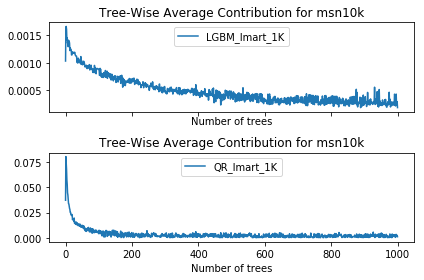

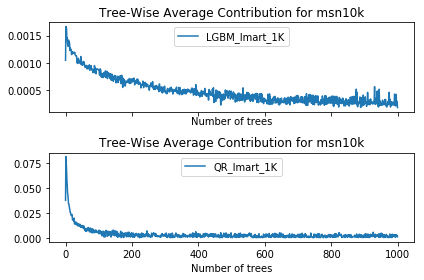

In [19]:
from rankeval.visualization.effectiveness import plot_tree_wise_average_contribution

figure = plot_tree_wise_average_contribution(msn_tree_contrib)
figure.show()

## 4. Query-Wise Performance

#### -> Computes query wise performance analysis

In [ ]:
from rankeval.analysis.effectiveness import query_wise_performance

msn_query_wise_perf = query_wise_performance(datasets=[msn_test], 
                            models=[msn_mart_50, msn_lmart_100], 
                            metrics=[precision_10, recall_10, ndcg_10],
                            bins=50)
print msn_query_wise_perf

#### -> Plot results

**plot_query_wise_performance** takes as input:
    - the query_wise_performance xarray (object) for given combinations of: dataset(s), model(s) and metric(s)
    - compare: str
        - the allowed values are: "models" and "metrics"
        - it allows the user to compare models or metrics

In [ ]:
from rankeval.visualization.effectiveness import plot_query_wise_performance

plot_query_wise_performance(msn_query_wise_perf, compare="models")
plot_query_wise_performance(msn_query_wise_perf, compare="metrics")

## 5. Document Graded Relevance

#### -> Computes document graded relevance analysis

In [ ]:
from rankeval.analysis.effectiveness import document_graded_relevance

istella_doc_graded_rel = document_graded_relevance(datasets=[istella_test], 
                               models=[istella_lmart_500], 
                               bins=50)
print istella_doc_graded_rel

msn_doc_graded_rel = document_graded_relevance(datasets=[msn_test], 
                                models=[msn_mart_50, msn_lmart_100],  
                                bins=50)
print msn_doc_graded_rel

#### -> Plot results

**plot_document_graded_relevance** takes as input:
    - the document_graded_relevance xarray (object) for given combinations of: dataset(s), model(s) and metric(s)

In [ ]:
from rankeval.visualization.effectiveness import plot_document_graded_relevance

plot_document_graded_relevance(istella_doc_graded_rel) 
plot_document_graded_relevance(msn_doc_graded_rel)

## 6. Rank-Confusion Matrix

#### -> Computes the rank confusion matrix analysis

In [ ]:
from rankeval.analysis.effectiveness import rank_confusion_matrix

istella_confusion_matrix = rank_confusion_matrix(datasets=[istella_test], 
                               models=[istella_lmart_500])
print istella_confusion_matrix

msn_confusion_matrix = rank_confusion_matrix(datasets=[msn_test], 
                                models=[msn_mart_50, msn_lmart_100])
print msn_confusion_matrix

#### -> Plot results

**plot_rank_confusion_matrix** takes as input:
    - the rank_confusion_matrix xarray (object) for given combinations of: dataset(s), model(s) and metric(s)

In [ ]:
from rankeval.visualization.effectiveness import plot_rank_confusion_matrix

plot_rank_confusion_matrix(df) 
plot_rank_confusion_matrix(df_msn) 

## 7. Query-Class Performance

#### -> Computes the query class performance analysis

In [ ]:
from rankeval.analysis.effectiveness import query_class_performance

classes = ['A', 'B', 'C', 'D', 'E']
query_classes = np.array([[classes[np.random.randint(len(classes))] 
                           for _ in range(istella.n_queries)]])

istella_query_class_perf = query_class_performance(datasets=[istella_test], 
                             models=[istella_lmart_500], 
                             metrics=[precision_10, recall_10, ndcg_10],
                             query_classes=query_classes)
print istella_query_class_perf

msn_query_class_perf = query_class_performance(datasets=[msn_test], 
                                 models=[msn_mart_50, msn_lmart_100],
                                 metrics=[precision_10, recall_10, ndcg_10],
                                 query_classes=query_classes)
print msn_query_class_perf


#### -> Plot results

**plot_query_class_performance** takes as input:
    - the query_class_performance xarray (object) for given combinations of: dataset(s), model(s) and metric(s)
    - compare: str
        - the allowed values are: "models" and "metrics"
        - it allows the user to compare models or metrics
    - show values: bool
        - shows the actual values on the plotted bars

In [ ]:
from rankeval.visualization.effectiveness import plot_query_class_performance

plot_query_class_performance(df, compare="metrics", show_values = True)
plot_query_class_performance(df, compare="models", show_values = True)